In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

#Extract the zip file
with zipfile.ZipFile('/content/brisc2025.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brisc2025_data')

print(os.listdir('/content/brisc2025_data'))

Saving brisc2025.zip to brisc2025.zip
['brisc2025']


In [ ]:
#preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

TRAIN_DIR = '/content/brisc2025_data/brisc2025/classification_task/train'
TEST_DIR = '/content/brisc2025_data/brisc2025/classification_task/test'

#train: augmentation + rescale
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

#val: rescale only
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VAL_SPLIT
)

#test: rescale only
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED,
    color_mode="rgb"
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED,
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb"
)

class_names = list(train_generator.class_indices.keys())
num_classes = train_generator.num_classes
print("Classes:", class_names)

import numpy as np
from collections import Counter

def print_class_counts(generator, set_name):

    #map the numbers (0,1,2,3) to the names
    class_labels = {v: k for k, v in generator.class_indices.items()}
    #count occurrences of each class index
    counts = Counter(generator.classes)

    print(f"\n {set_name} Class Breakdown")
    for index in sorted(counts.keys()):
        print(f"Class {index} ({class_labels[index]}): {counts[index]} images")

#run the count for all sets
print_class_counts(train_generator, "Training Set")
print_class_counts(val_generator, "Validation Set")
print_class_counts(test_generator, "Test Set")

Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

 Training Set Class Breakdown
Class 0 (glioma): 918 images
Class 1 (meningioma): 1064 images
Class 2 (no_tumor): 854 images
Class 3 (pituitary): 1166 images

 Validation Set Class Breakdown
Class 0 (glioma): 229 images
Class 1 (meningioma): 265 images
Class 2 (no_tumor): 213 images
Class 3 (pituitary): 291 images

 Test Set Class Breakdown
Class 0 (glioma): 254 images
Class 1 (meningioma): 306 images
Class 2 (no_tumor): 140 images
Class 3 (pituitary): 300 images


In [ ]:
#handle class imbalance

from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0898692810457515), 1: np.float64(0.9403195488721805), 2: np.float64(1.1715456674473068), 3: np.float64(0.8580617495711835)}


In [ ]:
#the Simple model puts activation='relu' inside the Conv2D layer By cutting off data early
#which makes the normalization less effective

from tensorflow.keras import layers, models

def build_simple_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    #initial Scanning
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #first residual block (32 Filters)
    shortcut = x
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut]) # Skip connection
    x = layers.MaxPooling2D((2, 2))(x)

    #second residual block (64 Filters)
    shortcut = layers.Conv2D(64, (1, 1), padding='same')(x) # Adjust shortcut to 64
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.MaxPooling2D((2, 2))(x)

    #third residual block (128 Filters)
    shortcut = layers.Conv2D(128, (1, 1), padding='same')(x) # Adjust shortcut to 128
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])

    #global Pooling is more advanced and helps with better accuracy
    x = layers.GlobalAveragePooling2D()(x)

    #final classification
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

#initialize the model
model = build_simple_resnet((128, 128, 3), 4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ add_2[0][0]     

 Total params: 342,660 (1.31 MB)

 Trainable params: 341,700 (1.30 MB)

 Non-trainable params: 960 (3.75 KB)

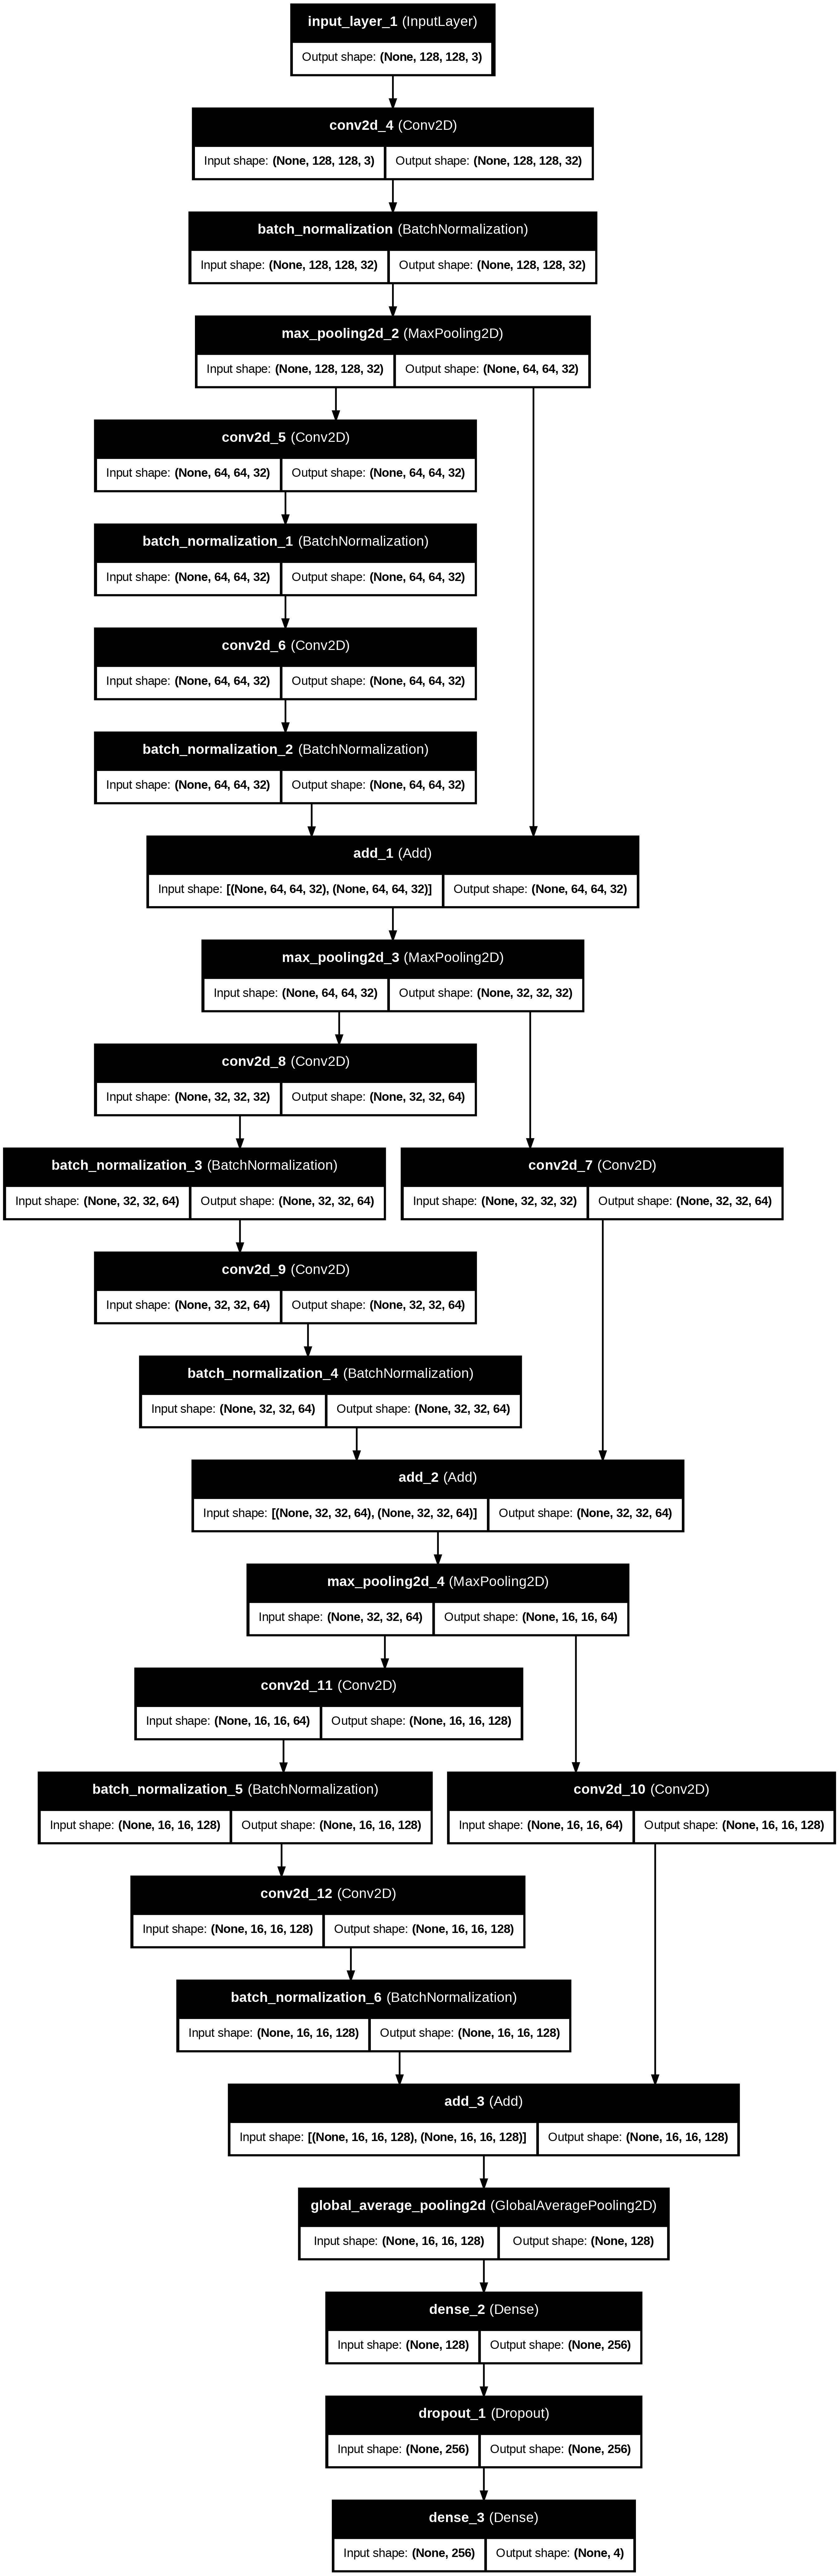

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

#display the image
from IPython.display import Image
Image('model_architecture.png')

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#slow down the learning rate if accuracy stops improving (lr=0.001 default)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#stop training if the model starts overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks_list = [reduce_lr, early_stop]


In [ ]:
#training
print("\nTraining: simple CNN")
history_custom = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

#evaluation
print("\nEvaluating: simple ResNet")
test_generator.reset()
eval_custom = model.evaluate(test_generator)

print(f"Test Loss: {eval_custom[0]:.4f}")
print(f"Test Accuracy: {eval_custom[1]*100:.2f}%")


Training: simple CNN
Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step - accuracy: 0.5579 - loss: 1.0796 - val_accuracy: 0.7756 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.7953 - loss: 0.5349 - val_accuracy: 0.7796 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.8344 - loss: 0.4266 - val_accuracy: 0.7735 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.8497 - loss: 0.3910 - val_accuracy: 0.7906 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.8559 - loss: 0.3927 - val_accuracy: 0.8216 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.8666 - loss: 0.3532 - val_accuracy: 0.7776 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 175m